## reference : https://github.com/JeCase/Thesis_SentimentAnalysis_IndoBERTweet_LSTM/blob/main/SentimentAnalysis_IndoBERTweet_ipnyb.ipynb

In [1]:
import gc
import re
import joblib
import operator
import string
from collections import defaultdict
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings #to modify warnings
warnings.filterwarnings('ignore') #ignoring warnings
sns.set_style('darkgrid')

from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, recall_score, precision_score

In [2]:
df = pd.read_csv("../data/dataHasilPreprocessing/hasilPreprocessing1.csv")
df

,Ulasan,Sentimen
0,ulas,Negatif
1,NaN,Negatif
2,bahan aja warna navy nya beda,Negatif
3,kasih catat order warna kuning navy baca kirim...,Negatif
4,kecil,Negatif
...,...,...
990,barang selamat terima kasih bahan celana nya s...,Negatif
991,kecil,Negatif
992,pesan cuna barang rusak coba konfirmasi tanggap,Negatif
993,karet pinggang nya kencang,Negatif


In [3]:
df = df.drop_duplicates(subset=['Ulasan'])

In [4]:
df = df.dropna()

In [5]:
df1 = df.copy()
arr = [df1]
for dataset in arr:    
  dataset.loc[(dataset['Sentimen'] == 'negatif'), 'Sentimen'] = 'Negatif'
  dataset.loc[(dataset['Sentimen'] == 'netral'), 'Sentimen'] = 'Netral'
  dataset.loc[(dataset['Sentimen'] == 'positif'), 'Sentimen'] = 'Positif'
df = df1

In [6]:
RANDOM_SEED = 42

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.1,
    random_state=RANDOM_SEED,
)

Sentimen
Positif    645
Negatif    112
Name: count, dtype: int64


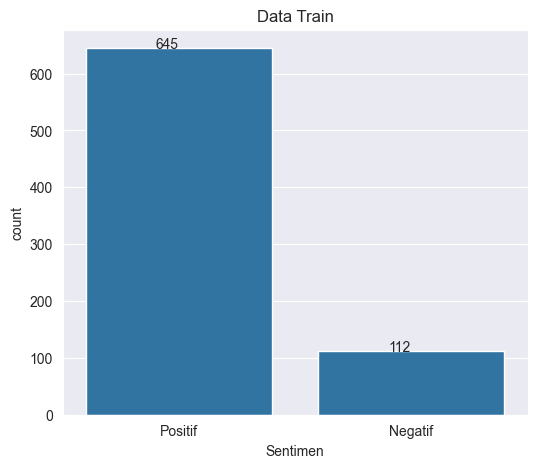

In [7]:
# Mengecek jumlah label "negatif": 0, "netral": 1, "positif": 2 pada data train
fig, ax = plt.subplots(figsize=(6, 5))
print(df_train['Sentimen'].value_counts())
ax = sns.countplot(x=df_train["Sentimen"])
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+0.05))
plt.title("Data Train")
plt.show()

Sentimen
Positif    150
Negatif     21
Name: count, dtype: int64


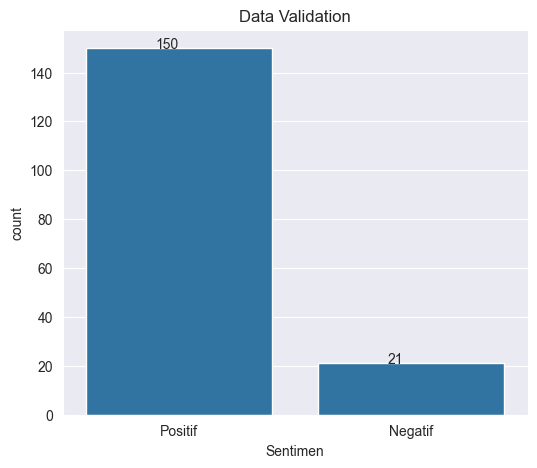

In [8]:
# Mengecek jumlah label "negatif": 0, "netral": 1, "positif": 2 pada data validasi
fig, ax = plt.subplots(figsize=(6, 5))
print(df_val['Sentimen'].value_counts())
ax = sns.countplot(x=df_val["Sentimen"])
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+0.05))
plt.title("Data Validation")
plt.show()

Sentimen
Positif    17
Negatif     2
Name: count, dtype: int64


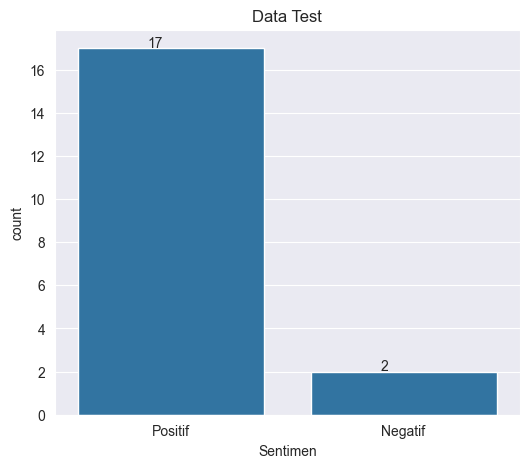

In [9]:
# Mengecek jumlah label "negatif": 0, "netral": 1, "positif": 2 pada data test
fig, ax = plt.subplots(figsize=(6, 5))
print(df_test['Sentimen'].value_counts())
ax = sns.countplot(x=df_test["Sentimen"])
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+0.05))
plt.title("Data Test")
plt.show()

In [10]:
print(f'Total Data Train    : {len(df_train)}')
print(f'Total Data Validasi : {len(df_val)}')
print(f'Total Data Test     : {len(df_test)}')

Total Data Train    : 757
Total Data Validasi : 171
Total Data Test     : 19


In [11]:
#Menyimpan data yang sudah dipisah kedalam google drive
df_train.to_csv("../data/dataHasilPreprocessing/train.csv", index=False)
df_val.to_csv("../data/dataHasilPreprocessing/eval.csv", index=False)
df_test.to_csv("../data/dataHasilPreprocessing/test.csv", index=False)

In [12]:
from datasets import load_dataset

files = {
    "train": "../data/dataHasilPreprocessing/train.csv", 
    "eval": "../data/dataHasilPreprocessing/eval.csv", 
    "test": "../data/dataHasilPreprocessing/test.csv",
}

dataset = load_dataset('csv', data_files=files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")

In [14]:
def tokenize_function(text):
    return tokenizer(text["Ulasan"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/757 [00:00<?, ? examples/s]

Map:   0%|          | 0/171 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

In [15]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]
test_dataset = tokenized_datasets["test"]

In [16]:
test_dataset

Dataset({
    features: ['Ulasan', 'Sentimen', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 19
})

In [17]:
cek_test = pd.DataFrame(test_dataset)
cek_test

,Ulasan,Sentimen,input_ids,token_type_ids,attention_mask
0,kain tipiss,Positif,"[3, 6907, 8799, 944, 4, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,jaitan rapih,Negatif,"[3, 7276, 2582, 21549, 4, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,haha gede karet ngga ketat longgar mmg rumah o...,Positif,"[3, 8692, 11008, 9648, 17055, 6638, 22719, 939...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
3,sesuai foto,Positif,"[3, 2768, 4724, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,wkwkwk banget ukur bahan tipis yahhh harga gin...,Positif,"[3, 7524, 10218, 14972, 2672, 8799, 24941, 266...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
5,bahan nya bagus banget cuman yng pkek orang ny...,Positif,"[3, 2672, 2647, 4839, 10218, 22713, 18039, 133...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,sesuai harga kecil sih,Positif,"[3, 2768, 2661, 2390, 6041, 4, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,oke coba versi make karet make tali ya bahan e...,Positif,"[3, 19114, 6008, 3869, 15906, 9648, 15906, 693...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
8,produk bagus sesuai gambar kirim cepat tks,Positif,"[3, 2392, 4839, 2768, 3894, 12159, 3218, 22183...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
9,bahan strech banget suka sih tipis kain bagus ...,Positif,"[3, 2672, 19203, 1840, 10218, 4346, 6041, 8799...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Train Model

In [23]:
import torch
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [24]:
from transformers import BertForSequenceClassification 
model = BertForSequenceClassification.from_pretrained("indolem/indobertweet-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "test_trainer", 
    per_device_train_batch_size=4,
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`